# Space Invader with Policy Gradient(Reinforce)

## Step 1: Import the libraries

In [70]:
import time
import gym
from gym import Env
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

%matplotlib inline

In [71]:
import sys
sys.path.append('../../')
from algos.agents import ReinforceAgent
from algos.models import ActorCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [72]:
class PenalizeDeathWrapper(gym.RewardWrapper):
    def __init__(self, env: Env):
        self.env = env
        self.currLives = 3
        self.newLives = 3
        self.baseReward = 0
        
    def step(self, action):
        """Modifies the reward using :meth:`self.reward` after the environment :meth:`env.step`."""
        observation, reward, terminated, info = self.env.step(action)
        self.newLives = info["lives"]
        self.baseReward = reward
        return observation, self.reward(reward), terminated, info

    def reward(self, reward):
        if (self.newLives < self.currLives):
            reward -= 100 #Severely penalize death.
            self.currLives = self.newLives
        return reward

In [73]:
env = PenalizeDeathWrapper(gym.make('ALE/SpaceInvaders-v5'))
env.seed(0)

(2968811710, 3677149159)

In [74]:
# if gpu is to be used
device = torch.device("cuda")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


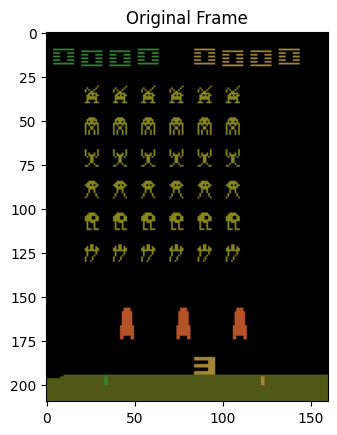

In [75]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play Pong with a random policy.

In [76]:
def random_play():
    score = 0
    env.reset()
    while True:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += env.baseReward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

Your Score at end of game is:  -190.0


## Step 4:Preprocessing Frame

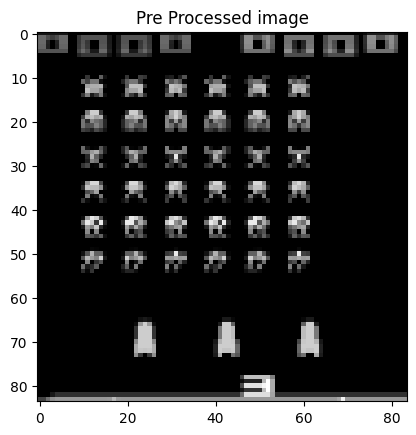

In [77]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [78]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Step 6: Creating our Agent

In [79]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99        # discount factor
LR= 0.0001          # Learning rate

agent = ReinforceAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, LR, ActorCnn)

## Step 7: Watching untrained agent play

In [80]:

# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    action, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [81]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

In [82]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        while True:
            action, log_prob = agent.act(state)
            next_state, reward, done, info = env.step(action)
            score += env.baseReward
            next_state = stack_frames(state, next_state, False)
            agent.step(log_prob, reward, done)
            state = next_state
            if done:
                break
        agent.learn()
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
            clear_output(True)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            x = np.arange(0, len(scores), 100)
            y = np.add.reduceat(scores, x) / 100
            plt.plot(x, y)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    
    return scores

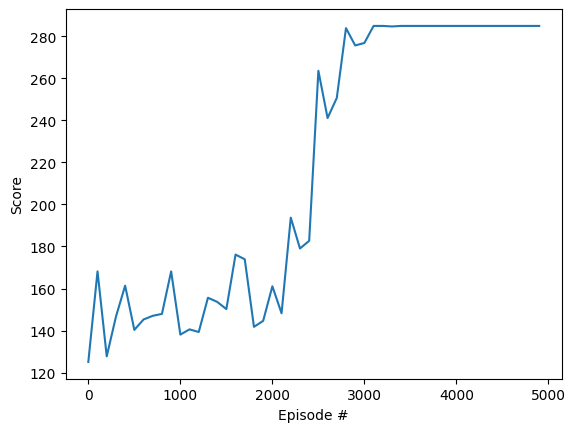

Elapsed Time: 9018.64718 seconds
Max score achieved: 855.0


In [83]:
start = time.time()
scores = train(5000)
end = time.time()
print("Elapsed Time: {:.5f} seconds".format(end - start))
print("Max score achieved: {}".format(np.amax(scores)))

## Step 10: Watch a Smart Agent!

In [ ]:
gym.logger.set_level(gym.logger.DEBUG)
env = PenalizeDeathWrapper(gym.make('ALE/SpaceInvaders-v5', render_mode = "human"))
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    action, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += env.baseReward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()